<a href="https://colab.research.google.com/github/PGM-Lab/2023-ProbAI/blob/main/Day2-BeforeLunch/notebooks/students_simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise

<center>
<img src="https://github.com/PGM-Lab/2022-ProbAI/raw/main/Day2-BeforeLunch/notebooks/Figures/students_simple_model.png" alt="Drawing" width="650">
</center>


### Imports

In [7]:
%matplotlib inline
import numpy as np
from scipy import special, stats
import matplotlib.pyplot as plt


### Startup: Define priors, and sample artificial training data

In [8]:
# Define priors
alpha_prior, beta_prior = 1E-2, 1E-2   # Parameters for the prior over gamma
mu_prior = 0 # A priori mean for mu
tau_prior = 1E-6  # A priori precision for mu

# Sample data
np.random.seed(123)
N = 100
correct_mean = 5
correct_precision = 1
x = np.random.normal(loc=correct_mean, scale=1./np.sqrt(correct_precision), size=N)

## Helper-routine: Make plot of density

In [9]:
#@title
def plot_density(posterior_mean_mu, posterior_prec_mu,
                   posterior_alpha_gamma, posterior_beta_gamma,
                   correct_mean, correct_precision):
    mu_range = np.linspace(-15,15, 500).astype(np.float32)
    precision_range = np.linspace(1E-2, 3, 500).astype(np.float32)
    mu_mesh, precision_mesh = np.meshgrid(mu_range, precision_range)
    variational_log_pdf = \
        stats.norm.logpdf(mu_mesh, loc=posterior_mean_mu, scale=1. / np.sqrt(posterior_prec_mu)) + \
        stats.gamma.logpdf(x=precision_mesh,
                           a=posterior_alpha_gamma,
                           scale=1. / posterior_beta_gamma)
    plt.figure()
    plt.contour(mu_mesh, precision_mesh, variational_log_pdf, 25)
    plt.plot(correct_mean, correct_precision, "bo")
    plt.title('Density over $(\mu, \\tau)$. Blue dot: True parameters')
    plt.xlabel("Mean $\mu$")
    plt.ylabel("Precision $\\tau$")

## Helper-routine: Calculate ELBO

In [10]:
#@title
def calculate_ELBO(data, tau, alpha, beta, nu_p, tau_p, alpha_p, beta_p):
    """
    Helper routine: Calculate ELBO. Data is the sampled x-values, anything without a _p relates to the prior,
    everything _with_ a _p relates to the variational posterior.
    Note that we have no nu without a _p; we are simplifying by forcing this to be zero a priori

    Note: This function obviously only works when the model is as in this code challenge,
    and is not a general solution.

    :param data: The sampled data
    :param tau: prior precision for mu, the mean for the data generation
    :param alpha: prior shape of dist for gamma, the precision  of the data generation
    :param beta: prior rate of dist for gamma, the precision  of the data generation
    :param nu_p: VB posterior mean for the distribution of mu - the mean of the data generation
    :param tau_p: VB posterior precision for the distribution of mu - the mean of the data generation
    :param alpha_p: VB posterior shape of dist for gamma, the precision  of the data generation
    :param beta_p: VB posterior shape of dist for gamma, the precision  of the data generation
    :return: the ELBO
    """

    # We calculate ELBO as E_q log p(x,z) - E_q log q(z)
    # log p(x,z) here is log p(mu) + log p(gamma) + \sum_i log p(x_i | mu, gamma)

    # E_q log p(mu)
    log_p = -.5 * np.log(2 * np.pi) + .5 * np.log(tau) - .5 * tau * (1 / tau_p + nu_p * nu_p)

    # E_q log p(gamma)
    log_p = log_p + alpha * np.log(beta) + \
            (alpha - 1) * (special.digamma(alpha_p) - np.log(beta_p)) - beta * alpha_p / beta_p

    # E_q log p(x_i|mu, gamma)
    for xi in data:
        log_p += -.5 * np.log(2 * np.pi) \
                 + .5 * (special.digamma(alpha_p) - np.log(beta_p)) \
                 - .5 * alpha_p / beta_p * (xi * xi - 2 * xi * nu_p + 1 / tau_p + nu_p * nu_p)

    # Entropy of mu (Gaussian)
    entropy = .5 * np.log(2 * np.pi * np.exp(1) / tau_p)
    entropy += alpha_p - np.log(beta_p) + special.gammaln(alpha_p) \
               + (1 - alpha_p) * special.digamma(alpha_p)

    return log_p + entropy


## Do the VB

The task is to implemente the variational updating equations appearing below.

<center>
<img src="https://github.com/PGM-Lab/2022-ProbAI/raw/main/Day2-BeforeLunch/notebooks/Figures/updating_equations.png" alt="Drawing" width="650">
</center>

In [11]:
# Initialization
alpha_q = alpha_prior
beta_q = beta_prior
mu_q = 0
tau_q = tau_prior
previous_elbo = -np.inf

# Start iterating
print("\n" + 100 * "=" + "\n   VB iterations:\n" + 100 * "=")
for iteration in range(1000):
    # Update gamma distribution
    alpha_q = 0 ## Code the updating equation
    beta_q = beta_prior + .5 * np.sum(x * x) - mu_q * np.sum(x) + .5 * N * (1. / tau_q + mu_q * mu_q)

    # Update Gaussian distribution
    expected_gamma = 0 ## Code the updating equation
    tau_q = 0.1 ## Code the updating equation
    mu_q = 0 ## Code the updating equation
    
    # Calculate Lower-bound
    current_elbo = calculate_ELBO(data=x, tau=tau_prior, alpha=alpha_prior, beta=beta_prior,
                                    nu_p=mu_q, tau_p=tau_q, alpha_p=alpha_q, beta_p=beta_q)
    
    print("{:2d}:  ELBO: {:12.7f}, alpha_q: {:6.3f}, beta_q: {:12.3f}, nu_q: {:6.3f}, tau_q: {:6.3f}".format(
        iteration + 1,  current_elbo, alpha_q, beta_q, mu_q, tau_q))
    
    if current_elbo < previous_elbo:
        raise ValueError("ELBO is decreasing. Something is wrong! Goodbye...")
    
    if iteration > 0 and np.abs((current_elbo - previous_elbo) / previous_elbo) < 1E-20:
        # Very little improvement. We are done.
        break
    
    # If we didn't break we need to run again. Update the value for "previous"
    previous_elbo = current_elbo
    

print("\n" + 100 * "=" + "\n   Result:\n" + 100 * "=")
print("E[mu] = {:5.3f} with data average {:5.3f} and prior mean {:5.3f}.".format(mu_q, np.mean(x), 0.))
print("E[gamma] = {:5.3f} with inverse of data covariance {:5.3f} and prior {:5.3f}.".format(
    alpha_q / beta_q, 1. / np.cov(x), alpha_prior / beta_prior))


   VB iterations:
 1:  ELBO:          nan, alpha_q:  0.000, beta_q: 50001327.248, nu_q:  0.000, tau_q:  0.100
 2:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 3:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 4:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 5:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 6:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 7:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 8:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
 9:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
10:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
11:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.24

<ipython-input-10-089099d1e68e>:34: RuntimeWarning: invalid value encountered in double_scalars
  log_p += -.5 * np.log(2 * np.pi) \
<ipython-input-10-089099d1e68e>:40: RuntimeWarning: invalid value encountered in double_scalars
  entropy += alpha_p - np.log(beta_p) + special.gammaln(alpha_p) \



75:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
76:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
77:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
78:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
79:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
80:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
81:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
82:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
83:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
84:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, tau_q:  0.100
85:  ELBO:          nan, alpha_q:  0.000, beta_q:     1827.248, nu_q:  0.000, t

### Plot of the Prior density

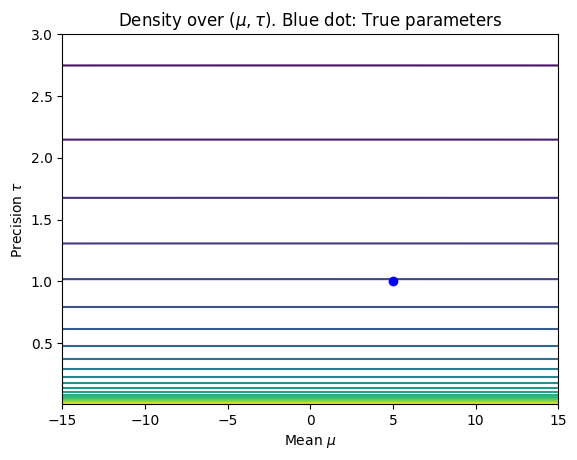

In [12]:
plot_density(mu_prior, tau_prior, alpha_prior, beta_prior, correct_mean, correct_precision)
plt.show()

### Plot of the Variational Posterior density

/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


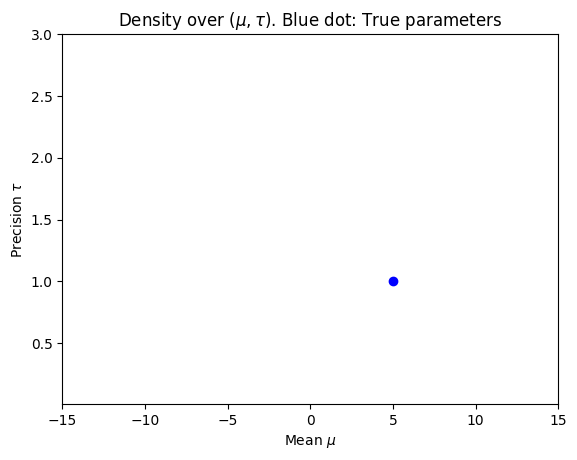

In [13]:
plot_density(mu_q, tau_q, alpha_q, beta_q, correct_mean, correct_precision)
plt.show()